# Gate infidelity calculation
This notebook uses physical value to calculate the gate infidelity of a two-qubit spin gate for electrons in Penning trap. The motional mode is assumed to be the axial mode.

Parameters:
Magnetic field gradient 250 T/m at 50 $\mu \mathrm{m}$ above the surface.
$\frac{d^3B}{dz^3}=-7.2\times 10^9\ \mathrm{T/m}^3$.

We scan the axial frequency from 10 MHz to 1GHz.

A1 in data is amplitude/L, with L representing the unit size 150  $\mu \mathrm{m}$

In [1]:
using Unitful
import PhysicalConstants.CODATA2022:ħ,k_B,μ_B
using CairoMakie
using FileIO
using QuantumToolbox
using CSV
using DataFrames
include("../scripts/infidelities_funnctions.jl");

In [11]:
function gradient_coupling(b,ω,m=1u"me")
    x0=zero_point_motion(ω,m=m)
    return u"MHz"(μ_B*b*x0/2ħ) # 2 accounts for the notation in [PRA 105, 022437 (2022)](https://link.aps.org/doi/10.1103/PhysRevA.105.022437).
end
function zero_point_motion(ω;m=1u"me")
    return sqrt(ħ/(2*m*ω))
end
function gradient_inhomogeneity_3(b3,ω,m=1u"me")
    x0=zero_point_motion(ω,m=m)
    return u"MHz"(μ_B*b3*x0^3/4ħ)
end

gradient_inhomogeneity_3 (generic function with 2 methods)

In [13]:
gradient_coupling(250u"T/m",2π*1u"GHz")

1.0550913573375198 MHz

In [14]:
gradient_inhomogeneity_3(-7.2e9u"T/m^3",2pi*1u"GHz")

-1.3996835518753004e-7 MHz

## Anharmonicity
In principle, one should include the anharmonic terms into the Hamiltonian to get result. Here, for quick check, I treat the effect of anharmonicity as static frequency shifts for different amplitudes since the potential now have no low-order anharmonicity based on Kento's calculation and the tool for high order terms is not established yet in this repository.

In [71]:
df_frequency_shift=CSV.read(raw"..\data\frequency shift\A1_vs_omega_N10S6.csv",DataFrame)
base_frequency=2π*(10:10:1000)u"MHz"
δ=(df_frequency_shift.omega.-1.0)*(base_frequency./gradient_coupling.(250u"T/m",base_frequency))'
Ω=ones(size(δ));

In [75]:
N = 30  
na=0
ψ0 = basis(2,1) ⊗ basis(2,1) ⊗ fock(N,na) #↓↓
Sx=sigmax() ⊗ qeye(2) + qeye(2) ⊗ sigmax() 
infidelity_values_theoretical = [real(infidelity_static_motional_shift(δ,Ω,na,ptrace(ψ0,(1,2)),Sx,1)) for (δ,Ω) in zip(δ,Ω)];
# ptrace(ψ0,(1,2))
infidelity_values_numerical = [real(infidelity_static_motional_shift_numerical(Ω,δ,ψ0, progress_bar=Val(false))) for (δ,Ω) in zip(δ,Ω)];

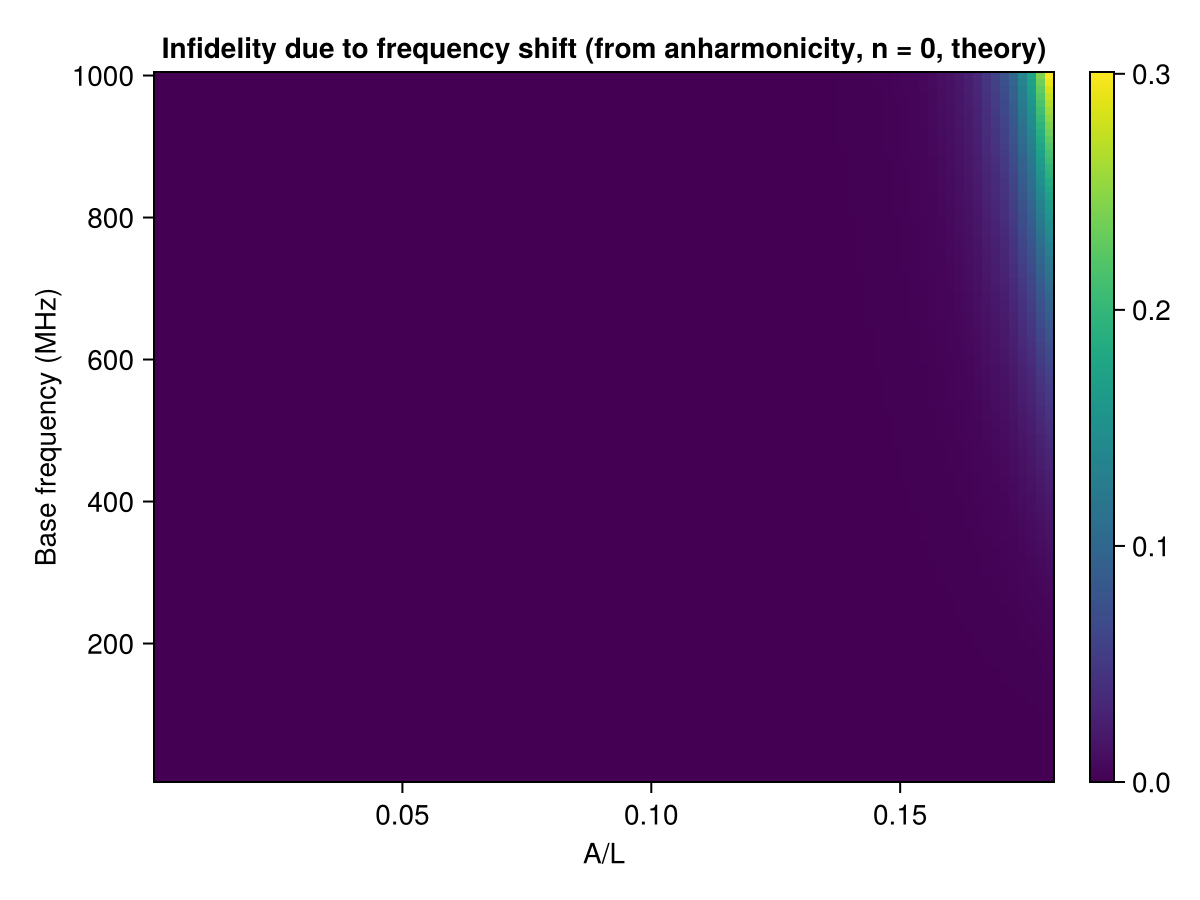

In [74]:
fig=Figure()
ax=Axis(fig[1,1],xlabel="A/L",ylabel="Base frequency (MHz)",title="Infidelity due to frequency shift (from anharmonicity, n = 0, theory)")
# ax2 = Axis(fig[1, 1], xaxisposition = :top")
# hidespines!(ax2)
# hideydecorations!(ax2)
hm=heatmap!(ax,(df_frequency_shift.A1),(base_frequency|>ustrip)/2pi,infidelity_values_theoretical)
Colorbar(fig[1,2],hm)
fig

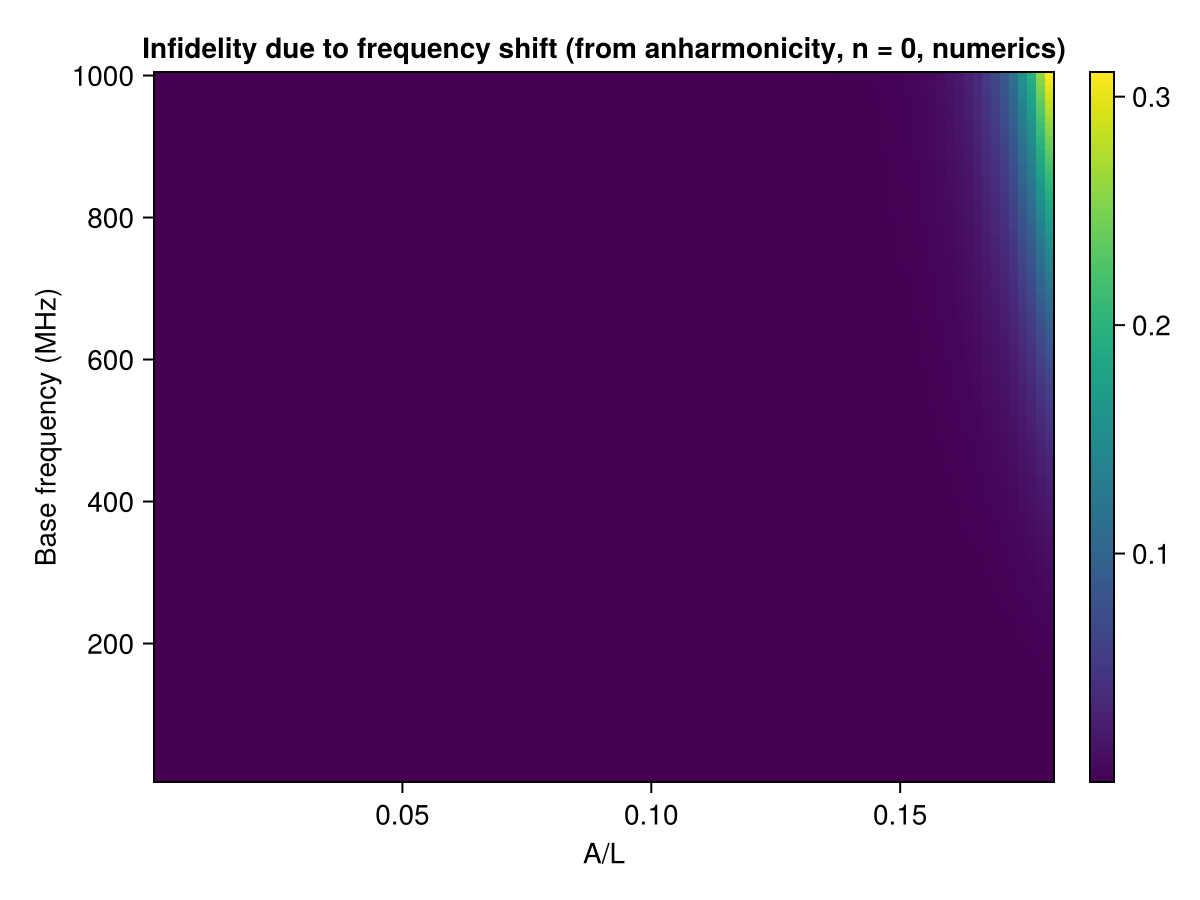

In [76]:
fig=Figure()
ax=Axis(fig[1,1],xlabel="A/L",ylabel="Base frequency (MHz)",title="Infidelity due to frequency shift (from anharmonicity, n = 0, numerics)")
# ax2 = Axis(fig[1, 1], xaxisposition = :top")
# hidespines!(ax2)
# hideydecorations!(ax2)
hm=heatmap!(ax,(df_frequency_shift.A1),(base_frequency|>ustrip)/2pi,infidelity_values_numerical)
Colorbar(fig[1,2],hm)
fig

## Magnetic gradient inhomogeneity 

In [62]:
let 
    N = 150  
    na = 28
    ψ0 = basis(2,1) ⊗ basis(2,1) ⊗ fock(N,na) #↓↓
    Sx=sigmax() ⊗ qeye(2) + qeye(2) ⊗ sigmax() 
    Ω2_test = upreferred(gradient_inhomogeneity_3(1.5e-7u"T/μm^3",2pi*300u"MHz")/gradient_coupling(120u"T/m",2pi*300u"MHz"))
    println("Theory: ",real(infidelity_field_inhomogeneity(Ω2_test,1,na,ptrace(ψ0,(1,2)),Sx,1)))
    println("Numerics: ",real(infidelity_field_inhomogeneity_numerical(1,Ω2_test,ψ0, progress_bar=Val(false))))
end


Theory: 2.8213401926213454e-5
Numerics: 4.103075331873818e-5


In [37]:
0.4u"K"*k_B/(ħ*2pi*300u"MHz")|>upreferred

27.78215883110343

In [42]:
b=250u"T/m"
b3=-7.2e9u"T/m^3"

base_frequency=2π*(100:10:1000)u"MHz"
Ω2s=[upreferred(gradient_inhomogeneity_3(b3,ω)/gradient_coupling(b,ω)) for ω in base_frequency]

91-element Vector{Float64}:
 -1.3265993907933667e-6
 -1.2059994461757882e-6
 -1.105499492327806e-6
 -1.0204610698410518e-6
 -9.475709934238339e-7
 -8.843995938622443e-7
 -8.291246192458543e-7
 -7.803525828196277e-7
 -7.369996615518702e-7
 -6.982102056807194e-7
 -6.632996953966837e-7
 -6.31713995615889e-7
 -6.029997230878941e-7
  ⋮
 -1.4905611132509743e-7
 -1.4739993231037413e-7
 -1.4578015283443597e-7
 -1.4419558595580075e-7
 -1.42645095784233e-7
 -1.4112759476525176e-7
 -1.3964204113614383e-7
 -1.381874365409758e-7
 -1.3676282379313064e-7
 -1.353672847748334e-7
 -1.3399993846397648e-7
 -1.3265993907933667e-7

In [58]:
# N = 300  
na_native= @. upreferred(0.4u"K"*k_B/(ħ*base_frequency))
na=@. round(Int,na_native) #nbar at 400mK
N= na*3
ψ0_spin= basis(2,1) ⊗ basis(2,1) #↓↓
ψ0 =[ψ0_spin ⊗ fock(N,na) for (na,N) in zip(na,N)]
Sx=sigmax() ⊗ qeye(2) + qeye(2) ⊗ sigmax() 
infidelity_values_theoretical = [real(infidelity_field_inhomogeneity(Ω2,1,na,ψ0_spin,Sx,1)) for (Ω2,na) in zip(Ω2s,na_native)]
infidelity_values_numerical = [real(infidelity_field_inhomogeneity_numerical(1,Ω2,ψ0, progress_bar=Val(false))) for (Ω2,ψ0) in zip(Ω2s,ψ0)];

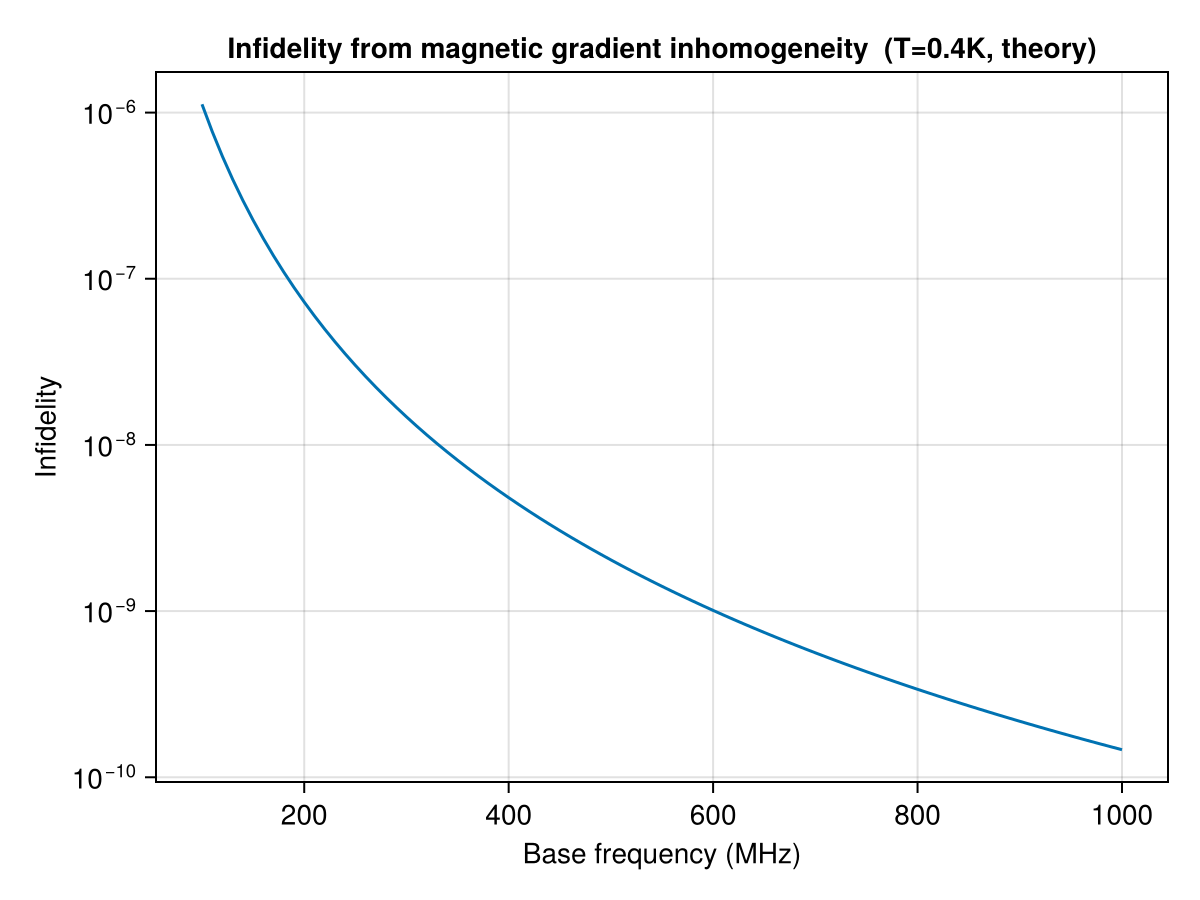

In [59]:
fig=Figure()
ax=Axis(fig[1,1],ylabel="Infidelity",xlabel="Base frequency (MHz)",title="Infidelity from magnetic gradient inhomogeneity  (T=0.4K, theory)",yscale=log10)

lines!(ax,(base_frequency|>ustrip)/2pi,infidelity_values_theoretical)
fig

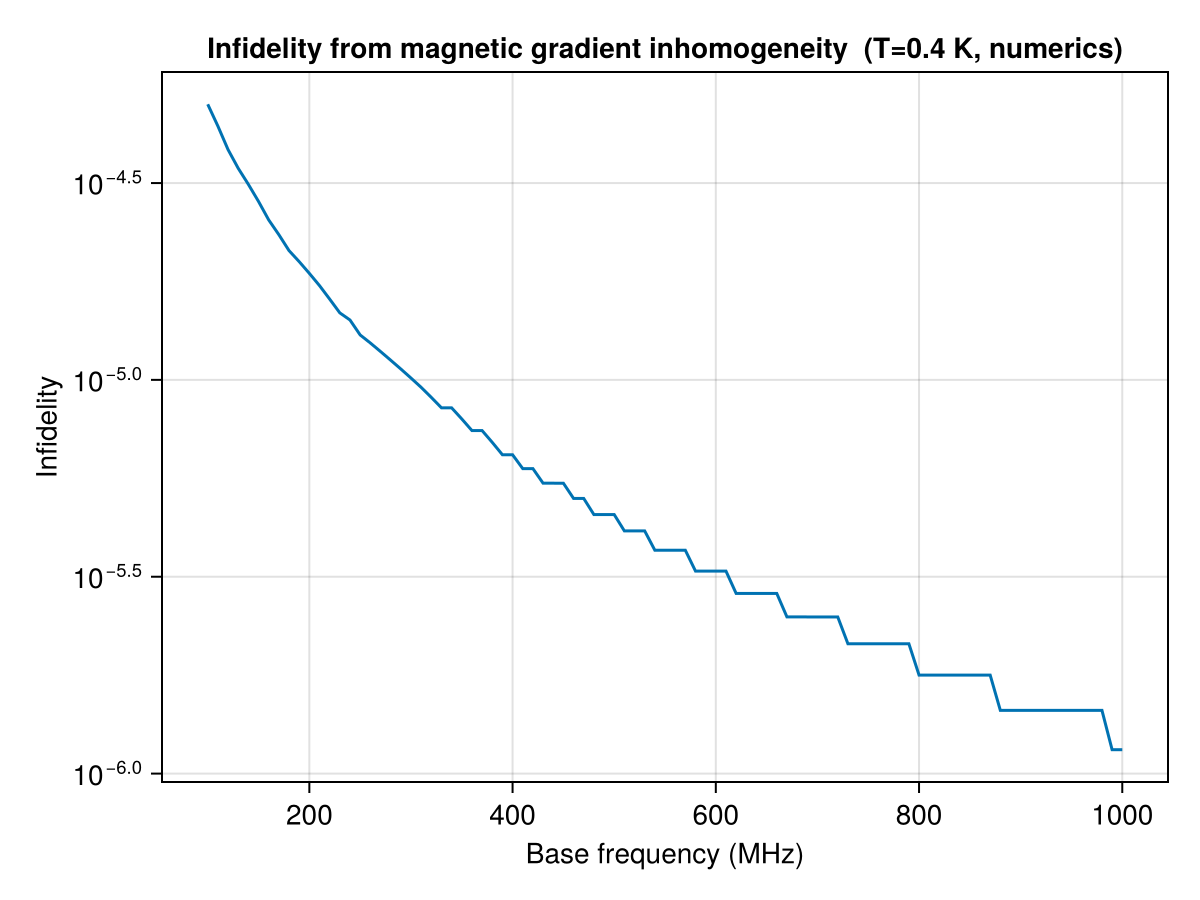

In [60]:
fig=Figure()
ax=Axis(fig[1,1],ylabel="Infidelity",xlabel="Base frequency (MHz)",title="Infidelity from magnetic gradient inhomogeneity  (T=0.4 K, numerics)",yscale=log10)

lines!(ax,(base_frequency|>ustrip)/2pi,infidelity_values_numerical)

fig